# Weather in Tromsø over time

## Hypothesis

The hypothesis of this project is split into different parts with the focus being on how the weather in Tromsø has changed over the weather. 
1. The temperatrue in Tromsø has increased, more than the global average
2. The weather has become more extreme, with higher temperatures and stronger winds classified as extreme (top 5%)
3. The winters in Tromsø has become shorter and arrives later in the season
4. There exists some local differences between the different sensors, especially depending on the geography

## Requirements

Includes nessesary libraries as well as some global variables and changes that needs to be included for the code in this program to run

In [ ]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt 
import reading_data as rd


In [95]:
#Midlertidig løsning for å oppdatere reading_data
import importlib
importlib.reload(rd)


<module 'reading_data' from '/Users/tha222/git-folder/troms_weather/scripts/reading_data.py'>

In [ ]:
client_id = '../client_files/client_id.txt'
client_secret = '../client_files/client_secret.txt'
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

## Finding the weather stations of Tromsø

Where ate the stations we have? And how old are they? 

In [9]:
station_id = pd.DataFrame(rd.FindingStations(client_id, client_secret
                                             ).get_sensors(69.95, 18.95, 30, "TROMSØ"),
                                             columns=['station_id', 'name'])

start_date, coor, names = [], [], []
for station in station_id['station_id']:
    location = rd.ReadingData(station, client_id, client_secret)
    start, end, coordinates, name = location.get_station_info()
    start_date.append(start)
    coor.append(coordinates)
    names.append(name)


In [10]:
station_id['date'] = start_date
station_id['year'] = pd.to_datetime(station_id['date']).dt.strftime('%Y')
station_id['lon'] = [cor[0] for cor in coor]
station_id['lat'] = [cor[1] for cor in coor]
station_id['name'] = names
station_id.sort_values(by='date', inplace=True)


In [11]:
station_id.reset_index(drop=True, inplace=True)
station_id


,station_id,name,date,year,lon,lat
0,SN90450,Tromsø (Vervarslinga),1895-08-01,1895,18.93680,69.65370
1,SN90490,Tromsø LH,1964-09-30,1964,18.91330,69.67670
2,SN90400,Tromsø (Holt),1987-05-04,1987,18.90950,69.65380
3,SN90491,Stor-Kjølen,1998-04-02,1998,18.78750,69.73330
4,SN90720,Måsvik,2003-10-08,2003,18.69380,69.99030
5,SN91020,Breivikeidet,2003-12-05,2003,19.51030,69.63670
6,SN90980,Oldervik,2003-12-05,2003,19.66470,69.75650
7,SN90721,Gråhaugen,2005-08-04,2005,18.70530,69.99970
8,SN90495,Stakkevollan,2011-10-20,2011,18.98200,69.69420
9,SN90451,Tromsø PLU,2011-10-20,2011,18.93650,69.65370


In [12]:
station_coordinates = gpd.GeoDataFrame(station_id, 
                                       geometry=gpd.points_from_xy(
                                           station_id.lon, station_id.lat))
station_coordinates.crs = 'EPSG:4326'
station_coordinates.head(20)


,station_id,name,date,year,lon,lat,geometry
0,SN90450,Tromsø (Vervarslinga),1895-08-01,1895,18.93680,69.65370,POINT (18.9368 69.6537)
1,SN90490,Tromsø LH,1964-09-30,1964,18.91330,69.67670,POINT (18.9133 69.6767)
2,SN90400,Tromsø (Holt),1987-05-04,1987,18.90950,69.65380,POINT (18.9095 69.6538)
3,SN90491,Stor-Kjølen,1998-04-02,1998,18.78750,69.73330,POINT (18.7875 69.7333)
4,SN90720,Måsvik,2003-10-08,2003,18.69380,69.99030,POINT (18.6938 69.9903)
5,SN91020,Breivikeidet,2003-12-05,2003,19.51030,69.63670,POINT (19.5103 69.6367)
6,SN90980,Oldervik,2003-12-05,2003,19.66470,69.75650,POINT (19.6647 69.7565)
7,SN90721,Gråhaugen,2005-08-04,2005,18.70530,69.99970,POINT (18.7053 69.9997)
8,SN90495,Stakkevollan,2011-10-20,2011,18.98200,69.69420,POINT (18.982 69.6942)
9,SN90451,Tromsø PLU,2011-10-20,2011,18.93650,69.65370,POINT (18.9365 69.6537)


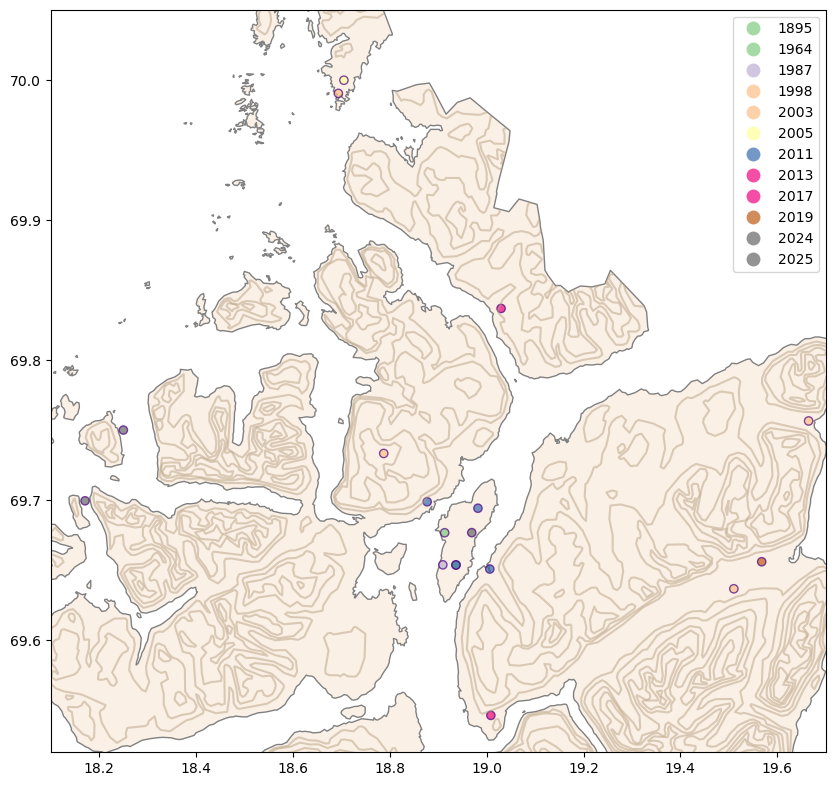

In [13]:
gdf = gpd.read_file('../data/Kommuner-L.geojson')
hoyde = gpd.read_file('../data/Basisdata_55_Troms_25833_N1000Hoyde_GML.gml', 
                      layer='Høydekurve')
hoyde = hoyde.to_crs(gdf.crs)
tromso = gdf[gdf['name'] == 'Tromsø']
clipped_hoyde = gpd.clip(hoyde, tromso)
fig, ax = plt.subplots(figsize=(10, 10))
tromso.plot(ax=ax, color="linen", edgecolor="grey")
clipped_hoyde.plot(ax=ax, color="xkcd:taupe", markersize=0.1, alpha=0.5)
station_coordinates.plot(ax=ax, column='year', cmap='Accent', marker='o', legend=True, 
          alpha=0.7, edgecolor='indigo')
ax.set_xlim(18.1,19.7)
ax.set_ylim(69.52,70.05)
plt.show()


In [14]:
chosen_stations = station_coordinates.iloc[[0, 1, 3, 4, 6]]
chosen_stations


,station_id,name,date,year,lon,lat,geometry
0,SN90450,Tromsø (Vervarslinga),1895-08-01,1895,18.9368,69.6537,POINT (18.9368 69.6537)
1,SN90490,Tromsø LH,1964-09-30,1964,18.9133,69.6767,POINT (18.9133 69.6767)
3,SN90491,Stor-Kjølen,1998-04-02,1998,18.7875,69.7333,POINT (18.7875 69.7333)
4,SN90720,Måsvik,2003-10-08,2003,18.6938,69.9903,POINT (18.6938 69.9903)
6,SN90980,Oldervik,2003-12-05,2003,19.6647,69.7565,POINT (19.6647 69.7565)


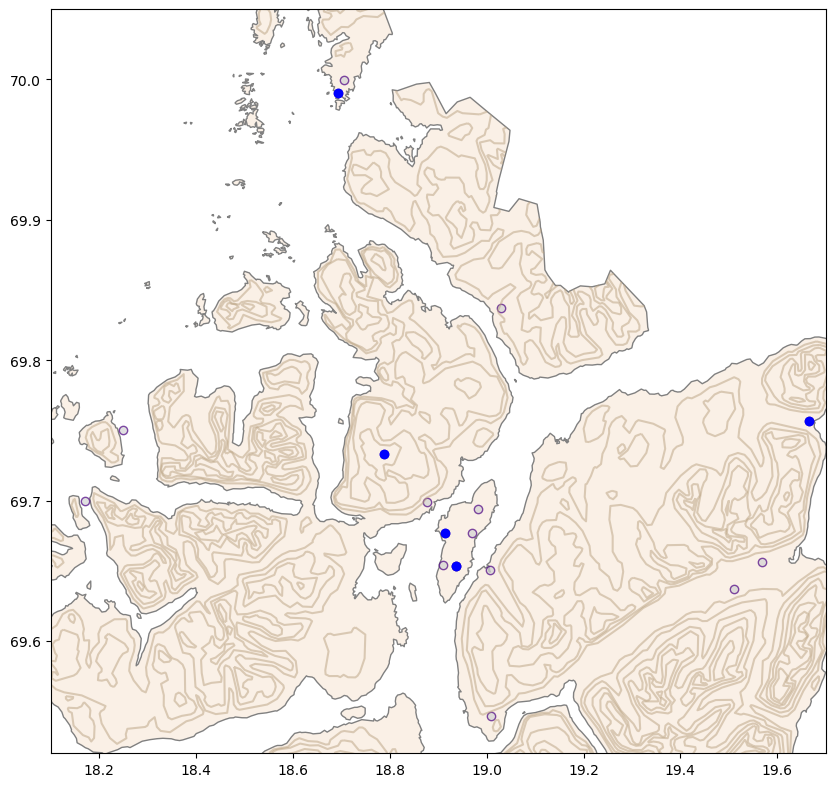

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
tromso.plot(ax=ax, color="linen", edgecolor="grey")
clipped_hoyde.plot(ax=ax, color="xkcd:taupe", markersize=0.1, alpha=0.5)
station_coordinates.plot(ax=ax, color='lightgrey', marker='o', legend=True, 
          alpha=0.7, edgecolor='indigo')
chosen_stations.plot(ax=ax, color='Blue', marker='o', legend=True)
ax.set_xlim(18.1,19.7)
ax.set_ylim(69.52,70.05)
plt.show()


## Has the temperature increased over the years?

In [62]:
vervarslinga = rd.ReadingData('SN90450', client_id, client_secret)
temperature_yearly = vervarslinga.get_temperature_yearly('1885','2024')


/var/folders/58/mh9t9nbj63zg6nbnj_qfkq_w0000gp/T/ipykernel_45072/577189049.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


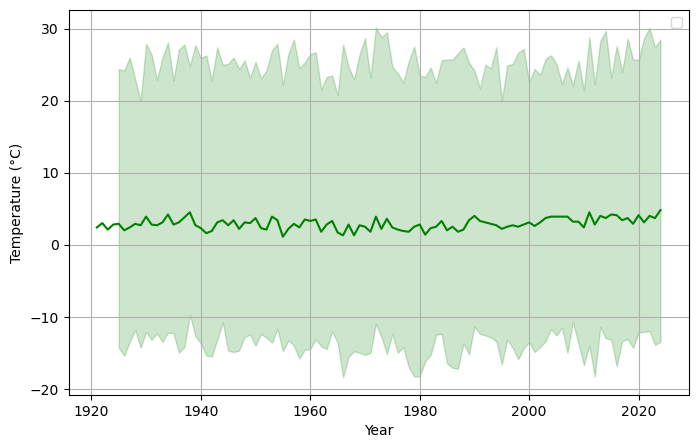

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(temperature_yearly['year'], temperature_yearly['mean'], linestyle='-', color='green')
plt.fill_between(temperature_yearly['year'], temperature_yearly['min'], temperature_yearly['max'], color='green', alpha=0.2)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
#Getting all the temperature data for the spring
spring_temperature = pd.DataFrame()
for year in range(1925, 2025):
    spring_temperature = pd.concat([spring_temperature, vervarslinga.get_temperature_daily(str(year)+'-03-01', str(year)+'-05-31')])


In [23]:
#Getting all the summer data
summer_temperature = pd.DataFrame()
for year in range(1925, 2025):
    summer_temperature = pd.concat([summer_temperature, vervarslinga.get_temperature_daily(str(year)+'-06-01', str(year)+'-08-31')])


In [24]:
#Getting all the atumn data
atumn_temperature = pd.DataFrame()
for year in range(1925, 2025):
    atumn_temperature = pd.concat([atumn_temperature, vervarslinga.get_temperature_daily(str(year)+'-09-01', str(year)+'-11-30')])


In [25]:
#Getting all the winter data
winter_temperature = pd.DataFrame()
for year in range(1925, 2025):
    winter_temperature = pd.concat([winter_temperature, vervarslinga.get_temperature_daily(str(year)+'-12-01', str(year+1)+'-02-28')])


In [26]:
for frames in [spring_temperature, summer_temperature, atumn_temperature, winter_temperature]:
    frames['date'] = pd.to_datetime(frames['date'])
    frames['year'] = frames['date'].dt.year
    frames['month_day'] = frames['date'].dt.strftime("%m-%d")


In [61]:
summer_heatmap = alt.Chart(summer_temperature,
    title=alt.Title("Summer Temperature 1925-2024",
    subtitle='Daily temperature from June 1st to August 31st over 99 years')
    ).mark_rect().encode(
    x=alt.X("year:O", title="Year", axis=alt.Axis(labelAngle=-45, 
                                                  values = list(range(1920, 2026, 5)))),
    y=alt.Y("month_day:N", title="Day of Summer", sort=None, axis=alt.Axis(labelAngle=0,
                                                                           values = ['06-01', '06-15', '07-01', '07-15', '08-01', '08-15', '08-30'])),
    color=alt.Color("temperature:Q", scale=alt.Scale(scheme="reds", domain=[10, 25]), title="Avg Temp (°C)"),
    tooltip=["year", "month_day", "temperature"]
).properties(
    width=900,
    height=500,   
)

summer_heatmap.show()


alt.Chart(...)

In [7]:
amomaly_temperature = vervarslinga.get_temperature_anomaly('1925', '2024')
amomaly_temperature.head()


,year,month,anomaly,year_month
0,1925,3,-0.6,1925-03
1,1925,6,1.0,1925-06
2,1925,9,-0.8,1925-09
3,1925,12,-0.1,1925-12
4,1926,3,-0.4,1926-03


In [54]:
color_change = alt.datum.anomaly > 0

alt.Chart(amomaly_temperature,
title=alt.Title("Temperatue change over time",
subtitle='Temperature Anomaly (°C compared to the 1960-1991 normal')
).mark_bar(
    bandSize=40,
).encode(
    x = alt.X("year_month:O", axis=alt.Axis(labelAngle=0,
                                            labelExpr='substring(datum.value, 0, 4)',
                                            values=['1925-03', '1935-03', '1945-03', '1955-03', '1965-03', '1975-03', '1985-03', '1995-03', '2005-03', '2015-03', '2024-03'],
                                            labelOverlap=True, ticks=False), title="Year"),
    y =alt.Y('anomaly:Q', title="Temperature Anomaly (°C)"),
    color=alt.Color('anomaly:Q',  # Use 'value' for coloring
                    scale=alt.Scale(scheme='redblue', domain=[5, -5])), 
).properties(
    width=600,
    height=400,
)


alt.Chart(...)

## Extreme weather

In [ ]:
daily_temp = (pd.concat([summer_temperature, winter_temperature, atumn_temperature, spring_temperature])
                 .assign(date=lambda x: pd.to_datetime(x['date']))
                 .sort_values('date')
                 .reset_index(drop=True))

daily_temp.head()


,date,temperature,year,month_day
0,1925-03-01,-7.9,1925,03-01
1,1925-03-02,-4.9,1925,03-02
2,1925-03-03,-1.0,1925,03-03
3,1925-03-04,-2.1,1925,03-04
4,1925-03-05,-4.4,1925,03-05


In [ ]:
extreme_temps = daily_temp.groupby("year").agg(
    extreme_hot=("temperature", lambda x: x.quantile(0.95)),  # Top 5% extreme heat
    extreme_cold=("temperature", lambda x: x.quantile(0.05))  # Bottom 5% extreme cold
).reset_index()


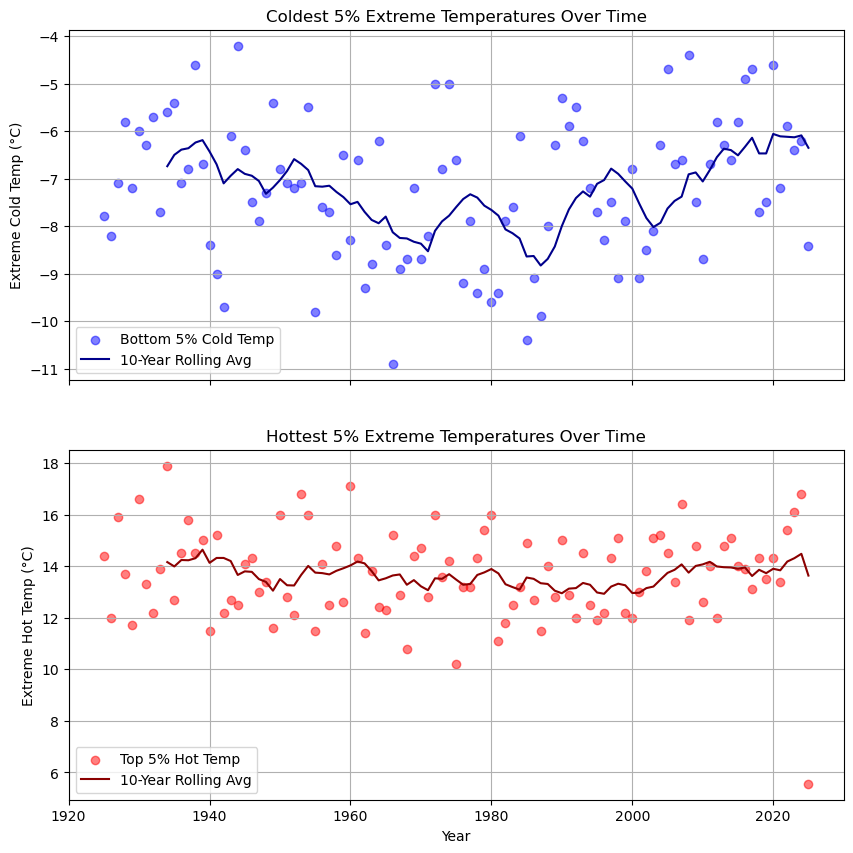

In [94]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

axes[0].scatter(extreme_temps["year"], extreme_temps["extreme_cold"], color='blue', alpha=0.5, label="Bottom 5% Cold Temp")
axes[0].plot(extreme_temps["year"], extreme_temps["extreme_cold"].rolling(10).mean(), color='darkblue', label="10-Year Rolling Avg")
axes[0].set_ylabel("Extreme Cold Temp (°C)")
axes[0].set_title("Coldest 5% Extreme Temperatures Over Time")
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(extreme_temps["year"], extreme_temps["extreme_hot"], color='red', alpha=0.5, label="Top 5% Hot Temp")
axes[1].plot(extreme_temps["year"], extreme_temps["extreme_hot"].rolling(10).mean(), color='darkred', label="10-Year Rolling Avg")
axes[1].set_ylabel("Extreme Hot Temp (°C)")
axes[1].set_xlabel("Year")
axes[1].set_title("Hottest 5% Extreme Temperatures Over Time")
axes[1].legend()
axes[1].grid(True)

plt.show()


In [ ]:
winter_heatmap = alt.Chart(winter_temperature).mark_rect().encode(    
    x=alt.X("year:O", title="Year", axis=alt.Axis(labelAngle=-45, 
                                                  values = list(range(1920, 2026, 5)))), 
    y=alt.Y("month_day:N", title="Day of Summer", sort=None),
    color=alt.Color("temperature:Q", scale=alt.Scale(scheme="blues", domain=[0, -20]), title="Avg Temp (°C)"),
    tooltip=["year", "month_day", "temperature"]
).properties(
    width=900,
    height=500,
    title="Winter Temperature Heatmap Over 99 Years"
)

winter_heatmap.show()


alt.Chart(...)